In [ ]:
!pip uninstall -y transformers tokenizers
!rm -rf /usr/local/lib/python3.*/dist-packages/transformers*
!rm -rf /usr/local/lib/python3.*/dist-packages/tokenizers*
!rm -rf ~/.cache/huggingface

!pip install transformers==4.28.0


import transformers
print(transformers.__version__)

Found existing installation: transformers 4.28.0
Uninstalling transformers-4.28.0:
  Successfully uninstalled transformers-4.28.0
Found existing installation: tokenizers 0.13.3
Uninstalling tokenizers-0.13.3:
  Successfully uninstalled tokenizers-0.13.3
  Using cached transformers-4.28.0-py3-none-any.whl.metadata (109 kB)
  Using cached tokenizers-0.13.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
Using cached transformers-4.28.0-py3-none-any.whl (7.0 MB)
Using cached tokenizers-0.13.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.8 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.4.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.28.0 which is incompatible.
4.28.0


In [ ]:
!pip install datasets

In [ ]:
import torch

In [ ]:
from datasets import load_dataset
from transformers import RobertaTokenizer

dataset = load_dataset("imdb")

train_dataset = dataset["train"].shuffle(seed=42).select(range(3000))
test_dataset = dataset["test"].shuffle(seed=42).select(range(2000))

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
train_dataset = train_dataset.map(
    lambda x: tokenizer(
        x["text"], padding="max_length", truncation=True, max_length=512
    ),
    batched=True,
)

test_dataset = test_dataset.map(
    lambda x: tokenizer(
        x["text"], padding="max_length", truncation=True, max_length=512
    ),
    batched=True,
)
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments
import time
from sklearn.metrics import accuracy_score


def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}


model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
model.train()

training_args = TrainingArguments(
    output_dir="./results",
    report_to="none",
    evaluation_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    save_total_limit=2,
    load_best_model_at_end=True,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()

# Timer start
start_time = time.time()

trainer.train()

# Timer end
end_time = time.time()

full_results=trainer.evaluate()

full_results["train_time_seconds"] = round(end_time - start_time, 2)
full_results["trainable_params"] = sum(p.numel() for p in model.parameters() if p.requires_grad)
full_results["gpu_memory_MB"] = round(torch.cuda.max_memory_allocated() / (1024 ** 2), 2)

# Print all results
print(full_results)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should pr

Epoch,Training Loss,Validation Loss,Accuracy
1,0.270300,0.238931,0.933000
2,0.199000,0.244334,0.942500
3,0.132500,0.245120,0.933500
4,0.060100,0.296917,0.936500
5,0.064600,0.288818,0.941500


{'eval_loss': 0.23893088102340698, 'eval_accuracy': 0.933, 'eval_runtime': 63.7004, 'eval_samples_per_second': 31.397, 'eval_steps_per_second': 1.962, 'epoch': 5.0, 'train_time_seconds': 1755.27, 'trainable_params': 124647170, 'gpu_memory_MB': 11559.4}


In [ ]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained("./results/checkpoint-940")
model.eval()

def predict(text):
    inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()

    label = "positive" if predicted_class == 1 else "negative"
    return label

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
review = "This movie was absolutely wonderful and inspiring!"
print(predict(review))

review = "Terrible plot and bad acting."
print(predict(review))

review = "I hates the movie. I had such high expectations but they failed"
print(predict(review))

positive
negative
negative


In [ ]:
# LORA
!pip install peft==0.3.0


In [ ]:
from peft import get_peft_model, LoraConfig, TaskType
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score
import torch
import time


def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

# Load base model
base_model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# LoRA config
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none"
)

# Wrap with LoRA
lora_model = get_peft_model(base_model, lora_config)
lora_model.train()

# Reset GPU usage
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

# Start timer

# Training arguments
lora_training_args = TrainingArguments(
    output_dir="./lora_results",
    report_to="none",
    evaluation_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./lora_logs",
    save_total_limit=2,
    load_best_model_at_end=True,
)


# Trainer
lora_trainer = Trainer(
    model=lora_model,
    args=lora_training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Train
start = time.time()
lora_trainer.train()
end = time.time()

# Evaluate
lora_results = lora_trainer.evaluate()
lora_results["train_time_seconds"] = round(end - start, 2)
lora_results["trainable_params"] = sum(p.numel() for p in lora_model.parameters() if p.requires_grad)
lora_results["gpu_memory_MB"] = round(torch.cuda.max_memory_allocated() / (1024**2), 2)

print(lora_results)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should pr

Epoch,Training Loss,Validation Loss,Accuracy
1,0.690700,0.685272,0.517500
2,0.672000,0.663364,0.867500
3,0.620000,0.621327,0.904000


{'eval_loss': 0.6213270425796509, 'eval_accuracy': 0.904, 'eval_runtime': 64.0042, 'eval_samples_per_second': 31.248, 'eval_steps_per_second': 1.953, 'epoch': 3.0, 'train_time_seconds': 841.87, 'trainable_params': 1479172, 'gpu_memory_MB': 9330.79}


In [ ]:
!pip install -U peft

!pip install peft==0.5.0


  Using cached peft-0.15.2-py3-none-any.whl.metadata (13 kB)
Using cached peft-0.15.2-py3-none-any.whl (411 kB)
  Attempting uninstall: peft
    Found existing installation: peft 0.5.0
    Uninstalling peft-0.5.0:
      Successfully uninstalled peft-0.5.0
  Using cached peft-0.5.0-py3-none-any.whl.metadata (22 kB)
Using cached peft-0.5.0-py3-none-any.whl (85 kB)
  Attempting uninstall: peft
    Found existing installation: peft 0.15.2
    Uninstalling peft-0.15.2:
      Successfully uninstalled peft-0.15.2


In [ ]:
from peft import IA3Config, get_peft_model, TaskType
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score
import torch
import time

# Load pretrained RoBERTa
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# IA3 configuration
ia3_config = IA3Config(
    task_type=TaskType.SEQ_CLS,
    target_modules=["query", "key", "value", "dense", "fc1", "fc2"],  # common for BERT/RoBERTa
    init_ia3_weights=True
)

# Inject IA3 adapters
model = get_peft_model(model, ia3_config)
model.train()

# Clear GPU memory
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

# Timer start
start_time = time.time()

# Training args
training_args = TrainingArguments(
    output_dir="./ia3_results",
    report_to="none",
    evaluation_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./ia3_logs",
    save_total_limit=2,
    load_best_model_at_end=True,
)

# Metric function
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Train and evaluate
trainer.train()
end_time = time.time()

# Evaluation
ia3_results = trainer.evaluate()
ia3_results["train_time_seconds"] = round(end_time - start_time, 2)
ia3_results["trainable_params"] = sum(p.numel() for p in model.parameters() if p.requires_grad)
ia3_results["gpu_memory_MB"] = round(torch.cuda.max_memory_allocated() / (1024**2), 2)

# Output metrics
print(ia3_results)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should pr

Epoch,Training Loss,Validation Loss,Accuracy
1,0.692800,0.685730,0.607000
2,0.680800,0.679126,0.587000
3,0.670700,0.672328,0.682000
4,0.666500,0.667232,0.730000
5,0.664800,0.665179,0.822500


{'eval_loss': 0.6651791930198669, 'eval_accuracy': 0.8225, 'eval_runtime': 64.7212, 'eval_samples_per_second': 30.902, 'eval_steps_per_second': 1.931, 'epoch': 5.0, 'train_time_seconds': 1464.94, 'trainable_params': 1296388, 'gpu_memory_MB': 12184.5}


In [ ]:
# Imports
import torch
import torch.nn as nn
from transformers import PreTrainedModel, RobertaModel, RobertaConfig
from transformers.modeling_outputs import SequenceClassifierOutput
from peft import get_peft_model, LoraConfig, TaskType
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score
import time

# Custom Model
class CustomQuantizedClassifier(PreTrainedModel):
    def __init__(self, backbone, config):
        super().__init__(config)
        self.backbone = backbone
        self.dropout = nn.Dropout(0.1)
        self.output_layer = nn.Linear(config.hidden_size, 2)

    def encode_inputs(self, input_ids=None, attention_mask=None, inputs_embeds=None, **extra_args):
        extra_args.pop("num_items_in_batch", None)
        return self.backbone(
            input_ids=input_ids,
            attention_mask=attention_mask,
            inputs_embeds=inputs_embeds,
            **extra_args
        )

    def forward(self, input_ids=None, attention_mask=None, labels=None, inputs_embeds=None, **kwargs):
        features = self.encode_inputs(
            input_ids=input_ids,
            attention_mask=attention_mask,
            inputs_embeds=inputs_embeds,
            **kwargs
        )
        cls_token = features.last_hidden_state[:, 0].float()
        logits = self.output_layer(self.dropout(cls_token))

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits
        )

# Metric Calculation
def evaluation_metrics(predictions):
    labels = predictions.label_ids
    preds = predictions.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

In [ ]:
from transformers import Trainer, TrainingArguments
import time
import torch
import pandas as pd
from tqdm import tqdm

def compute_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def run_training(model, output_folder, train_set, eval_set, lr=2e-5, epochs=5):
    args = TrainingArguments(
        output_dir=output_folder,
        overwrite_output_dir=True,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        learning_rate=lr,
        num_train_epochs=epochs,
        do_eval=False,
        save_strategy="no",
        logging_dir="./logs_custom",
        logging_steps=10,
        report_to="none",
        push_to_hub=False,
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_set,
        eval_dataset=eval_set,
        #tokenizer=tokenizer,
        compute_metrics=evaluation_metrics
    )

    torch.cuda.empty_cache()
    start_time = time.time()



    end_time = time.time()

    final_eval = trainer.evaluate(eval_dataset=eval_set)
    final_eval["train_time_seconds"] = round(end_time - start_time, 2)
    final_eval["trainable_params"] = sum(p.numel() for p in model.parameters() if p.requires_grad)
    final_eval["gpu_memory_MB"] = round(torch.cuda.max_memory_allocated() / (1024 ** 2), 2)

    print("\nFinal Evaluation:", final_eval)

    return final_eval


from transformers import BitsAndBytesConfig, RobertaModel
from peft import get_peft_model, LoraConfig, TaskType

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

quantized_encoder = RobertaModel.from_pretrained(
    "roberta-base",
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.float16
)

lora_config = LoraConfig(
    task_type=TaskType.FEATURE_EXTRACTION,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    target_modules=["query", "value"]
)

qlora_encoder = get_peft_model(quantized_encoder, lora_config)

from transformers import RobertaConfig

config = RobertaConfig.from_pretrained("roberta-base")
model_qlora = CustomQuantizedClassifier(backbone=qlora_encoder, config=config).to("cuda")


qlora_results = run_training(model_qlora, "./qlora_final", train_dataset, test_dataset)
print(qlora_results)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Final Evaluation: {'eval_loss': 0.6921828985214233, 'eval_model_preparation_time': 0.0059, 'eval_accuracy': 0.5005, 'eval_runtime': 16.0361, 'eval_samples_per_second': 124.719, 'eval_steps_per_second': 15.59, 'train_time_seconds': 0.0, 'trainable_params': 296450, 'gpu_memory_MB': 1402.92}
{'eval_loss': 0.6921828985214233, 'eval_model_preparation_time': 0.0059, 'eval_accuracy': 0.5005, 'eval_runtime': 16.0361, 'eval_samples_per_second': 124.719, 'eval_steps_per_second': 15.59, 'train_time_seconds': 0.0, 'trainable_params': 296450, 'gpu_memory_MB': 1402.92}


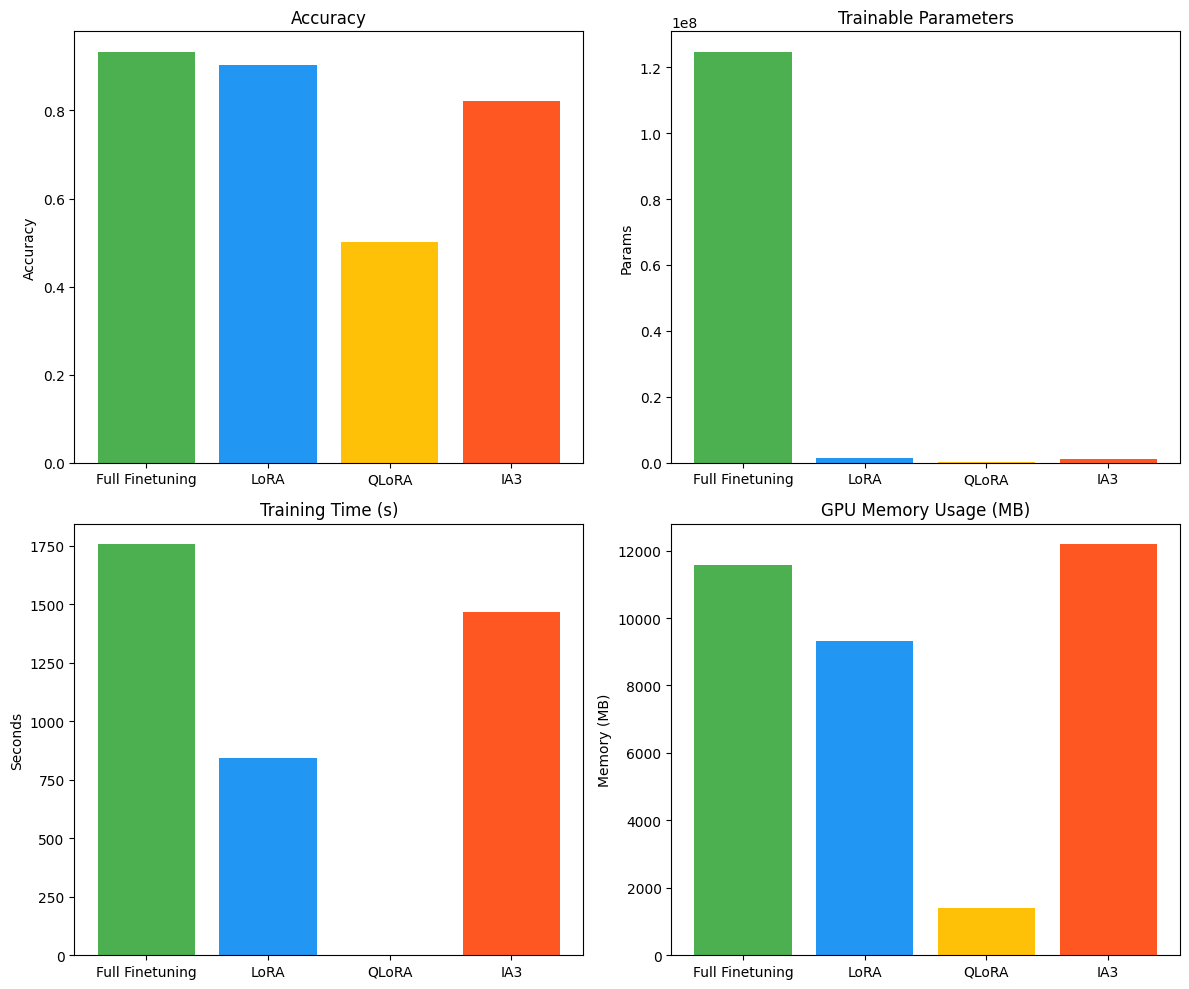

In [ ]:
import matplotlib.pyplot as plt

# Data
models = ["Full Finetuning", "LoRA", "QLoRA", "IA3"]
accuracies = [0.933, 0.904, 0.5005, 0.8225]
trainable_params = [124647170, 1479172, 296450, 1296388]
train_time = [1755.27, 841.87, 0.0, 1464.94]
gpu_memory = [11559.4, 9330.79, 1402.92, 12184.5]

# Plot
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
bar_width = 0.6
colors = ['#4CAF50', '#2196F3', '#FFC107', '#FF5722']

# Accuracy
axs[0, 0].bar(models, accuracies, color=colors)
axs[0, 0].set_title("Accuracy")
axs[0, 0].set_ylabel("Accuracy")

# Trainable Parameters
axs[0, 1].bar(models, trainable_params, color=colors)
axs[0, 1].set_title("Trainable Parameters")
axs[0, 1].set_ylabel("Params")

# Training Time
axs[1, 0].bar(models, train_time, color=colors)
axs[1, 0].set_title("Training Time (s)")
axs[1, 0].set_ylabel("Seconds")

# GPU Memory Usage
axs[1, 1].bar(models, gpu_memory, color=colors)
axs[1, 1].set_title("GPU Memory Usage (MB)")
axs[1, 1].set_ylabel("Memory (MB)")

plt.tight_layout()
plt.show()
